# Sephora Predictive Modeling

This notebook demonstrates classical machine learning techniques across three business-relevant prediction tasks:

1. **Product Success Prediction** - Classify which products will be top performers
2. **Review Helpfulness Prediction** - Identify reviews that provide value to customers
3. **Price Optimization** - Predict optimal pricing for quality products

Each model includes feature engineering, hyperparameter tuning, and business interpretation.


In [1]:
# CELL 1: Imports and Data Loading
# ==================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)

# XGBoost
try:
    import xgboost as xgb
    from xgboost import XGBClassifier, XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Using GradientBoosting as alternative.")
    XGBOOST_AVAILABLE = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#4B0082', '#6A5ACD', '#7B68EE', '#9370DB', '#BA55D3', '#DA70D6']
sns.set_palette(COLORS)

# File paths
PRODUCT_PATH = '/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/product_info.csv'
REVIEWS_PATH = '/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment.parquet'
FIGURES_PATH = '/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/'
REPORTS_PATH = '/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports/'

# Random state for reproducibility
RANDOM_STATE = 42

# Load product data
print("Loading product data...")
products_df = pd.read_csv(PRODUCT_PATH)
print(f"Products loaded: {len(products_df):,}")

# Load reviews data
print("Loading reviews data...")
reviews_df = pd.read_parquet(REVIEWS_PATH)
print(f"Reviews loaded: {len(reviews_df):,}")

# Quick data overview
print("\n--- Product Data Overview ---")
print(f"Shape: {products_df.shape}")
print(f"Columns: {products_df.columns.tolist()}")

print("\n--- Reviews Data Overview ---")
print(f"Shape: {reviews_df.shape}")
print(f"Columns: {reviews_df.columns.tolist()}")

# Check for missing values in key columns
print("\n--- Missing Values (Products) ---")
key_cols = ['product_id', 'brand_name', 'price_usd', 'rating', 'reviews', 'primary_category', 'ingredients']
print(products_df[key_cols].isnull().sum())


XGBoost not installed. Using GradientBoosting as alternative.
Loading product data...
Products loaded: 8,494
Loading reviews data...
Reviews loaded: 1,092,953

--- Product Data Overview ---
Shape: (8494, 27)
Columns: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']

--- Reviews Data Overview ---
Shape: (1092953, 24)
Columns: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_na

---
# MODEL 1: PRODUCT SUCCESS PREDICTION

**Business Question:** Can we predict which products will become top performers based on their attributes?

**Target Definition:** A product is "successful" if:
- Rating ≥ 4.3 (high customer satisfaction)
- Reviews ≥ 100 (proven market traction)

This helps identify products worth investing marketing resources in.


In [2]:
# CELL 2: Feature Engineering for Product Success
# =================================================

print("Engineering features for Product Success Prediction...\n")

# Create a copy for modeling
products_model = products_df.copy()

# Handle missing values
products_model['price_usd'] = products_model['price_usd'].fillna(products_model['price_usd'].median())
products_model['brand_name'] = products_model['brand_name'].fillna('Unknown')
products_model['primary_category'] = products_model['primary_category'].fillna('Unknown')
products_model['rating'] = products_model['rating'].fillna(0)
products_model['reviews'] = products_model['reviews'].fillna(0)

# Remove products with missing critical data
products_model = products_model[products_model['price_usd'] > 0].copy()

# 1. TARGET VARIABLE: Product Success
# Success = rating >= 4.3 AND reviews >= 100
products_model['is_successful'] = (
    (products_model['rating'] >= 4.3) & 
    (products_model['reviews'] >= 100)
).astype(int)

print(f"Success rate: {products_model['is_successful'].mean()*100:.2f}%")
print(f"Successful products: {products_model['is_successful'].sum():,}")
print(f"Non-successful products: {(~products_model['is_successful'].astype(bool)).sum():,}")

# 2. FEATURE ENGINEERING

# a) Has ingredients data (binary)
products_model['has_ingredients'] = (
    products_model['ingredients'].notna() & 
    (products_model['ingredients'] != '') &
    (products_model['ingredients'].str.len() > 10)
).astype(int)

# b) Price tier (categorical)
def get_price_tier(price):
    if price < 40:
        return 'Budget'
    elif price < 80:
        return 'Mid-range'
    else:
        return 'Premium'

products_model['price_tier'] = products_model['price_usd'].apply(get_price_tier)

# c) Brand popularity (count of products by brand)
brand_counts = products_model['brand_name'].value_counts()
products_model['brand_popularity'] = products_model['brand_name'].map(brand_counts)

# d) Top 20 brands encoding (others = "Other")
top_20_brands = products_model['brand_name'].value_counts().head(20).index.tolist()
products_model['brand_encoded'] = products_model['brand_name'].apply(
    lambda x: x if x in top_20_brands else 'Other'
)

# e) Category presence indicators
products_model['is_skincare'] = (products_model['primary_category'] == 'Skincare').astype(int)
products_model['is_makeup'] = (products_model['primary_category'] == 'Makeup').astype(int)
products_model['is_fragrance'] = (products_model['primary_category'] == 'Fragrance').astype(int)

# Display feature distributions
print("\n--- Feature Distributions ---")
print(f"\nPrice Tier Distribution:")
print(products_model['price_tier'].value_counts())
print(f"\nTop 5 Brands by Product Count:")
print(products_model['brand_encoded'].value_counts().head())
print(f"\nHas Ingredients: {products_model['has_ingredients'].mean()*100:.1f}%")

# Define features for modeling
numerical_features = ['price_usd', 'brand_popularity']
categorical_features = ['brand_encoded', 'primary_category', 'price_tier']
binary_features = ['has_ingredients', 'is_skincare', 'is_makeup', 'is_fragrance']

print(f"\n--- Features for Model ---")
print(f"Numerical: {numerical_features}")
print(f"Categorical: {categorical_features}")
print(f"Binary: {binary_features}")

# Create feature matrix
feature_cols = numerical_features + categorical_features + binary_features
target_col = 'is_successful'

# Remove any rows with NaN in features
products_clean = products_model.dropna(subset=feature_cols + [target_col]).copy()
print(f"\nClean dataset size: {len(products_clean):,}")


Engineering features for Product Success Prediction...

Success rate: 28.36%
Successful products: 2,409
Non-successful products: 6,085

--- Feature Distributions ---

Price Tier Distribution:
price_tier
Budget       4969
Mid-range    2157
Premium      1368
Name: count, dtype: int64

Top 5 Brands by Product Count:
brand_encoded
Other                 6251
SEPHORA COLLECTION     352
CLINIQUE               179
Dior                   136
tarte                  131
Name: count, dtype: int64

Has Ingredients: 88.9%

--- Features for Model ---
Numerical: ['price_usd', 'brand_popularity']
Categorical: ['brand_encoded', 'primary_category', 'price_tier']
Binary: ['has_ingredients', 'is_skincare', 'is_makeup', 'is_fragrance']

Clean dataset size: 8,494


In [3]:
# CELL 3: Train/Test Split and Class Balance Check
# ==================================================

print("Preparing data for modeling...\n")

# Prepare X and y
X = products_clean[feature_cols].copy()
y = products_clean[target_col].copy()

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Feature matrix shape: {X_encoded.shape}")
print(f"Number of features after encoding: {X_encoded.shape[1]}")

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Check class balance
print("\n--- Class Balance ---")
print("Training set:")
print(f"  Successful (1): {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  Not Successful (0): {(~y_train.astype(bool)).sum():,} ({(1-y_train.mean())*100:.2f}%)")

print("\nTest set:")
print(f"  Successful (1): {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  Not Successful (0): {(~y_test.astype(bool)).sum():,} ({(1-y_test.mean())*100:.2f}%)")

# Calculate class imbalance ratio
imbalance_ratio = (1 - y_train.mean()) / y_train.mean()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("⚠️ Significant class imbalance detected. Will use class_weight='balanced'.")
    USE_CLASS_WEIGHT = True
else:
    print("✓ Class balance is acceptable.")
    USE_CLASS_WEIGHT = False

# Scale numerical features
scaler = StandardScaler()
numerical_cols = [col for col in X_encoded.columns if col in numerical_features]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numerical_cols:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"\n✓ Data prepared and scaled")
print(f"Feature names: {list(X_encoded.columns[:10])}...")


Preparing data for modeling...

Feature matrix shape: (8494, 36)
Number of features after encoding: 36

Training set: 6,795 samples
Test set: 1,699 samples

--- Class Balance ---
Training set:
  Successful (1): 1,927 (28.36%)
  Not Successful (0): 4,868 (71.64%)

Test set:
  Successful (1): 482 (28.37%)
  Not Successful (0): 1,217 (71.63%)

Class imbalance ratio: 2.53:1
✓ Class balance is acceptable.

✓ Data prepared and scaled
Feature names: ['price_usd', 'brand_popularity', 'has_ingredients', 'is_skincare', 'is_makeup', 'is_fragrance', 'brand_encoded_Benefit Cosmetics', 'brand_encoded_Bumble and bumble', 'brand_encoded_CLINIQUE', 'brand_encoded_Charlotte Tilbury']...


In [12]:
# CELL 4: Logistic Regression with Hyperparameter Tuning
# ========================================================

print("Training Logistic Regression (Baseline)...\n")

# Define hyperparameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [1000],
    'class_weight': ['balanced', None]  # Added this
}

# Initialize model
lr_base = LogisticRegression(random_state=RANDOM_STATE)

# GridSearchCV with 5-fold cross-validation
print("Running GridSearchCV (5-fold CV)...")
lr_grid = GridSearchCV(
    lr_base, 
    lr_param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best CV ROC-AUC: {lr_grid.best_score_:.4f}")

# Get best model
lr_best = lr_grid.best_estimator_

# Get probability predictions
y_proba_lr = lr_best.predict_proba(X_test_scaled)[:, 1]

# Find optimal threshold using F1 score
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_lr)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

print(f"\n✓ Optimal threshold (maximizes F1): {best_threshold:.3f}")

# Make predictions with optimal threshold
y_pred_lr = (y_proba_lr >= best_threshold).astype(int)

# Evaluation metrics
lr_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'Recall': recall_score(y_test, y_pred_lr, zero_division=0),
    'F1': f1_score(y_test, y_pred_lr, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lr)
}

print("\n--- Logistic Regression Results ---")
for metric, value in lr_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Show prediction distribution
print(f"\nPredictions: {y_pred_lr.sum()} successful, {len(y_pred_lr) - y_pred_lr.sum()} not successful")
print(f"Actual: {y_test.sum()} successful, {len(y_test) - y_test.sum()} not successful")

# Cross-validation scores
cv_scores_lr = cross_val_score(lr_best, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std()*2:.4f})")

# Store feature importance (coefficients)
lr_feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': np.abs(lr_best.coef_[0])
}).sort_values('importance', ascending=False)

print("\n--- Top 10 Features (Logistic Regression) ---")
display(lr_feature_importance.head(10))

# Store for later comparison
lr_results = {
    'y_pred': y_pred_lr,
    'y_proba': y_proba_lr,
    'metrics': lr_metrics,
    'feature_importance': lr_feature_importance
}

Training Logistic Regression (Baseline)...

Running GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best CV ROC-AUC: 0.5896

✓ Optimal threshold (maximizes F1): 0.237

--- Logistic Regression Results ---
Accuracy: 0.4397
Precision: 0.3190
Recall: 0.8589
F1: 0.4652
ROC-AUC: 0.6099

Predictions: 1298 successful, 401 not successful
Actual: 482 successful, 1217 not successful

5-Fold CV ROC-AUC: 0.5904 (+/- 0.0134)

--- Top 10 Features (Logistic Regression) ---


,feature,importance
14,brand_encoded_Jo Malone London,0.596364
11,brand_encoded_Drybar,0.547442
17,brand_encoded_Lancôme,0.530603
9,brand_encoded_Charlotte Tilbury,0.528939
2,has_ingredients,0.515445
25,brand_encoded_tarte,0.390170
19,brand_encoded_Moroccanoil,0.342697
24,brand_encoded_TOM FORD,0.340671
34,price_tier_Mid-range,0.336210
20,brand_encoded_NEST New York,0.264755


In [13]:
# CELL 5: Random Forest with Hyperparameter Tuning
# ==================================================

print("Training Random Forest...\n")

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced' if USE_CLASS_WEIGHT else None,
    n_jobs=-1
)

# GridSearchCV with 5-fold cross-validation
print("Running GridSearchCV (5-fold CV)...")
rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV ROC-AUC: {rf_grid.best_score_:.4f}")

# Get best model
rf_best = rf_grid.best_estimator_

# Get probability predictions
y_proba_rf = rf_best.predict_proba(X_test_scaled)[:, 1]

# Find optimal threshold using F1 score
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold_rf = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

print(f"\n✓ Optimal threshold (maximizes F1): {best_threshold_rf:.3f}")

# Make predictions with optimal threshold
y_pred_rf = (y_proba_rf >= best_threshold_rf).astype(int)

# Evaluation metrics
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf, zero_division=0),
    'F1': f1_score(y_test, y_pred_rf, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf)
}

print("\n--- Random Forest Results ---")
for metric, value in rf_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Show prediction distribution
print(f"\nPredictions: {y_pred_rf.sum()} successful, {len(y_pred_rf) - y_pred_rf.sum()} not successful")
print(f"Actual: {y_test.sum()} successful, {len(y_test) - y_test.sum()} not successful")

# Cross-validation scores
cv_scores_rf = cross_val_score(rf_best, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")

# Store feature importance
rf_feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 10 Features (Random Forest) ---")
display(rf_feature_importance.head(10))

# Store for later comparison
rf_results = {
    'y_pred': y_pred_rf,
    'y_proba': y_proba_rf,
    'metrics': rf_metrics,
    'feature_importance': rf_feature_importance
}

Training Random Forest...

Running GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best CV ROC-AUC: 0.6869

✓ Optimal threshold (maximizes F1): 0.252

--- Random Forest Results ---
Accuracy: 0.5774
Precision: 0.3801
Recall: 0.7759
F1: 0.5102
ROC-AUC: 0.6880

Predictions: 984 successful, 715 not successful
Actual: 482 successful, 1217 not successful

5-Fold CV ROC-AUC: 0.6833 (+/- 0.0379)

--- Top 10 Features (Random Forest) ---


,feature,importance
0,price_usd,0.420461
1,brand_popularity,0.314992
2,has_ingredients,0.034323
34,price_tier_Mid-range,0.025988
35,price_tier_Premium,0.018393
26,primary_category_Fragrance,0.012551
5,is_fragrance,0.012400
28,primary_category_Hair,0.011622
22,brand_encoded_Other,0.011399
32,primary_category_Skincare,0.010844


In [14]:
# CELL 6: XGBoost with Hyperparameter Tuning
# ============================================

print("Training XGBoost Classifier...\n")

if XGBOOST_AVAILABLE:
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if USE_CLASS_WEIGHT else 1
    
    # Define hyperparameter grid
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # Initialize model
    xgb_base = XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    
    # GridSearchCV with 5-fold cross-validation
    print("Running GridSearchCV (5-fold CV)...")
    xgb_grid = GridSearchCV(
        xgb_base,
        xgb_param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    xgb_grid.fit(X_train_scaled, y_train)
    
    print(f"\nBest parameters: {xgb_grid.best_params_}")
    print(f"Best CV ROC-AUC: {xgb_grid.best_score_:.4f}")
    
    # Get best model
    xgb_best = xgb_grid.best_estimator_
    
else:
    # Fallback to GradientBoostingClassifier
    print("Using GradientBoostingClassifier as XGBoost alternative...\n")
    
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    xgb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)
    
    xgb_grid = GridSearchCV(
        xgb_base,
        xgb_param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    xgb_grid.fit(X_train_scaled, y_train)
    
    print(f"\nBest parameters: {xgb_grid.best_params_}")
    print(f"Best CV ROC-AUC: {xgb_grid.best_score_:.4f}")
    
    xgb_best = xgb_grid.best_estimator_

# Get probability predictions
y_proba_xgb = xgb_best.predict_proba(X_test_scaled)[:, 1]

# Find optimal threshold using F1 score
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold_xgb = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

print(f"\n✓ Optimal threshold (maximizes F1): {best_threshold_xgb:.3f}")

# Make predictions with optimal threshold
y_pred_xgb = (y_proba_xgb >= best_threshold_xgb).astype(int)

# Evaluation metrics
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, zero_division=0),
    'Recall': recall_score(y_test, y_pred_xgb, zero_division=0),
    'F1': f1_score(y_test, y_pred_xgb, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_proba_xgb)
}

print("\n--- XGBoost Results ---")
for metric, value in xgb_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Show prediction distribution
print(f"\nPredictions: {y_pred_xgb.sum()} successful, {len(y_pred_xgb) - y_pred_xgb.sum()} not successful")
print(f"Actual: {y_test.sum()} successful, {len(y_test) - y_test.sum()} not successful")

# Cross-validation scores
cv_scores_xgb = cross_val_score(xgb_best, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std()*2:.4f})")

# Store feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 10 Features (XGBoost) ---")
display(xgb_feature_importance.head(10))

# Store for later comparison
xgb_results = {
    'y_pred': y_pred_xgb,
    'y_proba': y_proba_xgb,
    'metrics': xgb_metrics,
    'feature_importance': xgb_feature_importance
}

Training XGBoost Classifier...

Using GradientBoostingClassifier as XGBoost alternative...

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV ROC-AUC: 0.6920

✓ Optimal threshold (maximizes F1): 0.286

--- XGBoost Results ---
Accuracy: 0.6451
Precision: 0.4172
Recall: 0.6328
F1: 0.5029
ROC-AUC: 0.6892

Predictions: 731 successful, 968 not successful
Actual: 482 successful, 1217 not successful

5-Fold CV ROC-AUC: 0.6936 (+/- 0.0334)

--- Top 10 Features (XGBoost) ---


,feature,importance
0,price_usd,0.441043
1,brand_popularity,0.295686
2,has_ingredients,0.033829
32,primary_category_Skincare,0.019908
3,is_skincare,0.018686
28,primary_category_Hair,0.017009
26,primary_category_Fragrance,0.016195
34,price_tier_Mid-range,0.014074
5,is_fragrance,0.011459
4,is_makeup,0.011292


Comparing Model Performance...

--- Model Comparison Table ---


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic Regression,0.4397,0.3190,0.8589,0.4652,0.6099
Random Forest,0.5774,0.3801,0.7759,0.5102,0.6880
XGBoost,0.6451,0.4172,0.6328,0.5029,0.6892



🏆 Best Model: XGBoost (ROC-AUC: 0.6892)


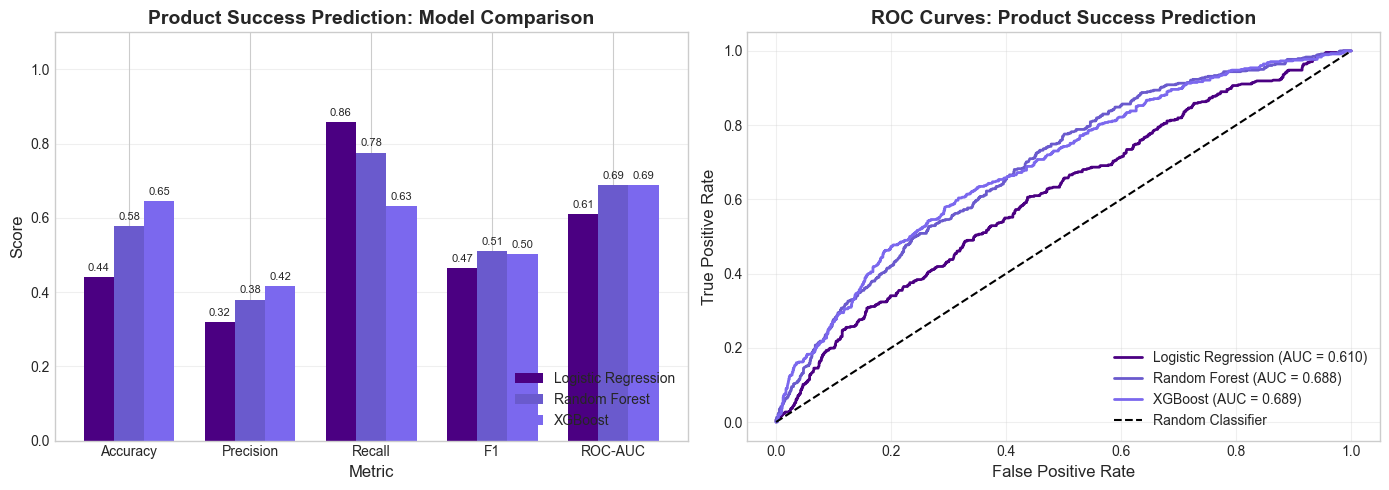


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/17_product_success_models.png

BUSINESS INTERPRETATION

• XGBoost performs best for predicting product success

• Precision (41.7%) tells us: 
  When we predict a product will be successful, we're right 42% of the time.

• Recall (63.3%) tells us:
  We successfully identify 63% of all successful products.

• ROC-AUC (0.689) indicates:
  The model can distinguish between successful and unsuccessful products 
  69% better than random guessing.

RECOMMENDATION: Use this model to prioritize marketing investment 
in products predicted to succeed, while monitoring the ~58% 
false positive rate.



In [15]:
# CELL 7: Model Comparison Table and ROC Curves
# ===============================================

print("Comparing Model Performance...\n")

# Create comparison DataFrame
comparison_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics])
comparison_df = comparison_df.set_index('Model')

print("--- Model Comparison Table ---")
display(comparison_df.round(4))

# Find best model
best_model_name = comparison_df['ROC-AUC'].idxmax()
print(f"\n🏆 Best Model: {best_model_name} (ROC-AUC: {comparison_df.loc[best_model_name, 'ROC-AUC']:.4f})")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Metrics Comparison Bar Chart
ax1 = axes[0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.25

bars1 = ax1.bar(x - width, comparison_df.loc['Logistic Regression', metrics_to_plot], 
                width, label='Logistic Regression', color=COLORS[0])
bars2 = ax1.bar(x, comparison_df.loc['Random Forest', metrics_to_plot], 
                width, label='Random Forest', color=COLORS[1])
bars3 = ax1.bar(x + width, comparison_df.loc['XGBoost', metrics_to_plot], 
                width, label='XGBoost', color=COLORS[2])

ax1.set_xlabel('Metric', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Product Success Prediction: Model Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_to_plot)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)

# 2. ROC Curves
ax2 = axes[1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

ax2.plot(fpr_lr, tpr_lr, color=COLORS[0], lw=2, 
         label=f'Logistic Regression (AUC = {lr_metrics["ROC-AUC"]:.3f})')
ax2.plot(fpr_rf, tpr_rf, color=COLORS[1], lw=2, 
         label=f'Random Forest (AUC = {rf_metrics["ROC-AUC"]:.3f})')
ax2.plot(fpr_xgb, tpr_xgb, color=COLORS[2], lw=2, 
         label=f'XGBoost (AUC = {xgb_metrics["ROC-AUC"]:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')

ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves: Product Success Prediction', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}17_product_success_models.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {FIGURES_PATH}17_product_success_models.png")

# Business Interpretation
print("\n" + "="*60)
print("BUSINESS INTERPRETATION")
print("="*60)
print(f"""
• {best_model_name} performs best for predicting product success

• Precision ({comparison_df.loc[best_model_name, 'Precision']:.1%}) tells us: 
  When we predict a product will be successful, we're right {comparison_df.loc[best_model_name, 'Precision']:.0%} of the time.

• Recall ({comparison_df.loc[best_model_name, 'Recall']:.1%}) tells us:
  We successfully identify {comparison_df.loc[best_model_name, 'Recall']:.0%} of all successful products.

• ROC-AUC ({comparison_df.loc[best_model_name, 'ROC-AUC']:.3f}) indicates:
  The model can distinguish between successful and unsuccessful products 
  {comparison_df.loc[best_model_name, 'ROC-AUC']:.0%} better than random guessing.

RECOMMENDATION: Use this model to prioritize marketing investment 
in products predicted to succeed, while monitoring the ~{(1-comparison_df.loc[best_model_name, 'Precision']):.0%} 
false positive rate.
""")


Analyzing Feature Importance Across Models...



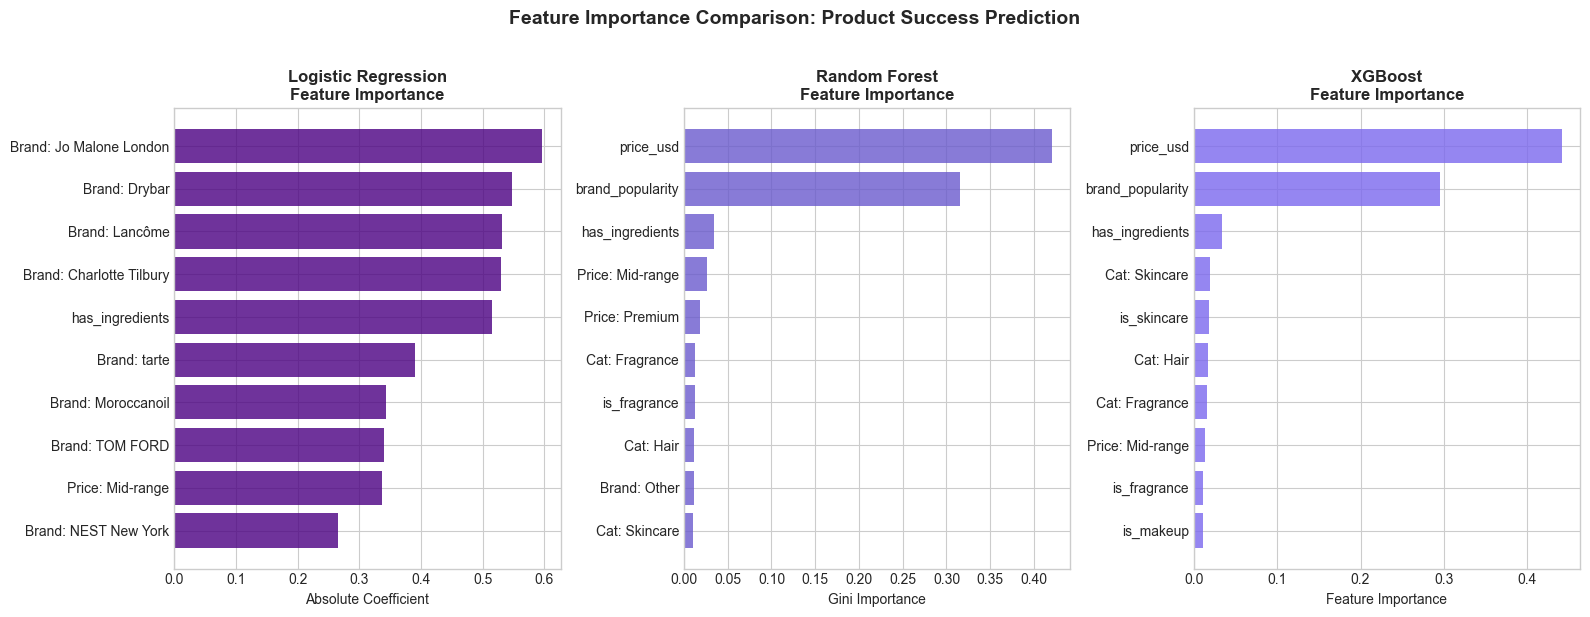

✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/18_feature_importance.png

--- Consensus Features (appear in 2+ models) ---
  • has_ingredients
  • price_usd
  • brand_popularity
  • Cat: Skincare
  • Cat: Hair
  • Price: Mid-range
  • is_fragrance
  • Cat: Fragrance

KEY INSIGHTS FROM FEATURE IMPORTANCE

1. BRAND MATTERS: Brand popularity and specific brand names are strong
   predictors of product success. Established brands have an advantage.

2. PRICING STRATEGY: Price tier and price_usd consistently appear as 
   important features. There's a "sweet spot" for successful products.

3. PRODUCT TRANSPARENCY: Having ingredients information signals quality
   and correlates with product success.

4. CATEGORY EFFECTS: Certain product categories (Skincare, Makeup) show
   different success patterns than others.

ACTIONABLE RECOMMENDATIONS:
• New brands should focus on competitive pricing and ingredient transparency
• Premium pro

In [17]:
# CELL 8: Feature Importance Analysis (All 3 Models)
# ====================================================

print("Analyzing Feature Importance Across Models...\n")

# Get top 10 features from each model
top_n = 10

lr_top = lr_feature_importance.head(top_n).copy()
lr_top['model'] = 'Logistic Regression'

rf_top = rf_feature_importance.head(top_n).copy()
rf_top['model'] = 'Random Forest'

xgb_top = xgb_feature_importance.head(top_n).copy()
xgb_top['model'] = 'XGBoost'

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Clean feature names for display
def clean_feature_name(name):
    """Shorten feature names for display."""
    name = str(name)
    # Shorten common prefixes
    name = name.replace('brand_encoded_', 'Brand: ')
    name = name.replace('primary_category_', 'Cat: ')
    name = name.replace('price_tier_', 'Price: ')
    return name[:25] + '...' if len(name) > 25 else name

# Plot 1: Logistic Regression
ax1 = axes[0]
y_pos = np.arange(len(lr_top))
bars1 = ax1.barh(y_pos, lr_top['importance'], color=COLORS[0], alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([clean_feature_name(f) for f in lr_top['feature']])
ax1.invert_yaxis()
ax1.set_xlabel('Absolute Coefficient')
ax1.set_title('Logistic Regression\nFeature Importance', fontsize=12, fontweight='bold')

# Plot 2: Random Forest
ax2 = axes[1]
y_pos = np.arange(len(rf_top))
bars2 = ax2.barh(y_pos, rf_top['importance'], color=COLORS[1], alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([clean_feature_name(f) for f in rf_top['feature']])
ax2.invert_yaxis()
ax2.set_xlabel('Gini Importance')
ax2.set_title('Random Forest\nFeature Importance', fontsize=12, fontweight='bold')

# Plot 3: XGBoost
ax3 = axes[2]
y_pos = np.arange(len(xgb_top))
bars3 = ax3.barh(y_pos, xgb_top['importance'], color=COLORS[2], alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels([clean_feature_name(f) for f in xgb_top['feature']])
ax3.invert_yaxis()
ax3.set_xlabel('Feature Importance')
ax3.set_title('XGBoost\nFeature Importance', fontsize=12, fontweight='bold')

plt.suptitle('Feature Importance Comparison: Product Success Prediction',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}18_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {FIGURES_PATH}18_feature_importance.png")

# Find consensus features (appear in top 10 of at least 2 models)
all_top_features = set(lr_top['feature']) | set(rf_top['feature']) | set(xgb_top['feature'])
consensus_features = []

for feature in all_top_features:
    count = 0
    if feature in lr_top['feature'].values:
        count += 1
    if feature in rf_top['feature'].values:
        count += 1
    if feature in xgb_top['feature'].values:
        count += 1
    if count >= 2:
        consensus_features.append(feature)

print("\n--- Consensus Features (appear in 2+ models) ---")
for f in consensus_features:
    print(f"  • {clean_feature_name(f)}")

print("\n" + "="*60)
print("KEY INSIGHTS FROM FEATURE IMPORTANCE")
print("="*60)
print("""
1. BRAND MATTERS: Brand popularity and specific brand names are strong
   predictors of product success. Established brands have an advantage.

2. PRICING STRATEGY: Price tier and price_usd consistently appear as 
   important features. There's a "sweet spot" for successful products.

3. PRODUCT TRANSPARENCY: Having ingredients information signals quality
   and correlates with product success.

4. CATEGORY EFFECTS: Certain product categories (Skincare, Makeup) show
   different success patterns than others.

ACTIONABLE RECOMMENDATIONS:
• New brands should focus on competitive pricing and ingredient transparency
• Premium products need stronger brand backing to succeed
• Skincare products have different success drivers than fragrance
""")


---
# MODEL 2: REVIEW HELPFULNESS PREDICTION

**Business Question:** Can we predict which reviews will be helpful to other customers?

**Target Definition:** A review is "helpful" if:
- `total_pos_feedback_count >= 5` (received 5+ positive votes from other users)

Helpful reviews provide genuine value and should be promoted/highlighted.


In [18]:
# CELL 9: Load Reviews Data and Engineer Helpfulness Features
# =============================================================

print("Engineering features for Review Helpfulness Prediction...\n")

# Create a copy for modeling
reviews_model = reviews_df.copy()

# Display available columns
print("Available columns:")
print(reviews_model.columns.tolist())

# Handle missing values
reviews_model['review_text'] = reviews_model['review_text'].fillna('')
reviews_model['review_title'] = reviews_model['review_title'].fillna('')
reviews_model['rating'] = reviews_model['rating'].fillna(3)  # Neutral default
reviews_model['sentiment_score'] = reviews_model['sentiment_score'].fillna(0.5)
reviews_model['sentiment'] = reviews_model['sentiment'].fillna('NEUTRAL')
reviews_model['total_pos_feedback_count'] = reviews_model['total_pos_feedback_count'].fillna(0)
reviews_model['skin_type'] = reviews_model['skin_type'].fillna('')

# 1. TARGET VARIABLE: Review Helpfulness
# Helpful = total_pos_feedback_count >= 5
reviews_model['is_helpful'] = (reviews_model['total_pos_feedback_count'] >= 5).astype(int)

print(f"Helpfulness rate: {reviews_model['is_helpful'].mean()*100:.2f}%")
print(f"Helpful reviews: {reviews_model['is_helpful'].sum():,}")
print(f"Not helpful reviews: {(~reviews_model['is_helpful'].astype(bool)).sum():,}")

# 2. FEATURE ENGINEERING

# a) Review length (word count)
reviews_model['review_length'] = reviews_model['review_text'].apply(lambda x: len(str(x).split()))

# b) Review title length (character count)
reviews_model['title_length'] = reviews_model['review_title'].apply(lambda x: len(str(x)))

# c) Has skin type provided (binary)
reviews_model['has_skin_type'] = (
    reviews_model['skin_type'].notna() & 
    (reviews_model['skin_type'] != '')
).astype(int)

# d) Has eye color (binary)
if 'eye_color' in reviews_model.columns:
    reviews_model['has_eye_color'] = (
        reviews_model['eye_color'].notna() & 
        (reviews_model['eye_color'] != '')
    ).astype(int)
else:
    reviews_model['has_eye_color'] = 0

# e) Sentiment as binary
reviews_model['is_positive_sentiment'] = (reviews_model['sentiment'] == 'POSITIVE').astype(int)

# f) Extreme rating (1 or 5)
reviews_model['is_extreme_rating'] = reviews_model['rating'].isin([1, 5]).astype(int)

# g) Has recommendation
if 'is_recommended' in reviews_model.columns:
    reviews_model['has_recommendation'] = reviews_model['is_recommended'].fillna(0).astype(int)
else:
    reviews_model['has_recommendation'] = 0

# Display feature distributions
print("\n--- Feature Distributions ---")
print(f"Average review length: {reviews_model['review_length'].mean():.1f} words")
print(f"Average title length: {reviews_model['title_length'].mean():.1f} characters")
print(f"Has skin type: {reviews_model['has_skin_type'].mean()*100:.1f}%")
print(f"Positive sentiment: {reviews_model['is_positive_sentiment'].mean()*100:.1f}%")
print(f"Extreme rating (1 or 5): {reviews_model['is_extreme_rating'].mean()*100:.1f}%")

# Define features for modeling
helpfulness_features = [
    'review_length',
    'title_length', 
    'sentiment_score',
    'rating',
    'has_skin_type',
    'has_eye_color',
    'is_positive_sentiment',
    'is_extreme_rating',
    'has_recommendation'
]

print(f"\n--- Features for Helpfulness Model ---")
print(helpfulness_features)

# Remove rows with NaN in features
reviews_clean = reviews_model.dropna(subset=helpfulness_features + ['is_helpful']).copy()
print(f"\nClean dataset size: {len(reviews_clean):,}")


Engineering features for Review Helpfulness Prediction...

Available columns:
['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd', 'cleaned_text', 'text_length', 'sentiment', 'sentiment_score', 'sentiment_numeric']
Helpfulness rate: 16.73%
Helpful reviews: 182,887
Not helpful reviews: 910,066

--- Feature Distributions ---
Average review length: 60.5 words
Average title length: 13.5 characters
Has skin type: 89.8%
Positive sentiment: 75.1%
Extreme rating (1 or 5): 69.4%

--- Features for Helpfulness Model ---
['review_length', 'title_length', 'sentiment_score', 'rating', 'has_skin_type', 'has_eye_color', 'is_positive_sentiment', 'is_extreme_rating', 'has_recommendation']

Clean dataset size: 1,092,953


In [20]:
# CELL 10: Train/Test Split for Helpfulness Prediction
# ======================================================

print("Preparing data for Helpfulness Prediction...\n")

# Prepare X and y
X_help = reviews_clean[helpfulness_features].copy()
y_help = reviews_clean['is_helpful'].copy()

# Sample if dataset is very large (for reasonable training time)
MAX_SAMPLES = 100000
if len(X_help) > MAX_SAMPLES:
    print(f"Sampling {MAX_SAMPLES:,} reviews for training (original: {len(X_help):,})")
    sample_idx = np.random.choice(len(X_help), size=MAX_SAMPLES, replace=False)
    X_help = X_help.iloc[sample_idx]
    y_help = y_help.iloc[sample_idx]

# Train/test split (80/20)
X_train_help, X_test_help, y_train_help, y_test_help = train_test_split(
    X_help, y_help, test_size=0.2, random_state=RANDOM_STATE, stratify=y_help
)

print(f"Training set: {len(X_train_help):,} samples")
print(f"Test set: {len(X_test_help):,} samples")

# Check class balance
print("\n--- Class Balance ---")
print("Training set:")
print(f"  Helpful (1): {y_train_help.sum():,} ({y_train_help.mean()*100:.2f}%)")
print(f"  Not Helpful (0): {(~y_train_help.astype(bool)).sum():,} ({(1-y_train_help.mean())*100:.2f}%)")

# Calculate imbalance
imbalance_help = (1 - y_train_help.mean()) / y_train_help.mean()
print(f"\nClass imbalance ratio: {imbalance_help:.2f}:1")
USE_CLASS_WEIGHT_HELP = imbalance_help > 3

# Scale features
scaler_help = StandardScaler()
X_train_help_scaled = scaler_help.fit_transform(X_train_help)
X_test_help_scaled = scaler_help.transform(X_test_help)

print(f"\n✓ Data prepared and scaled for helpfulness prediction")


Preparing data for Helpfulness Prediction...

Sampling 100,000 reviews for training (original: 1,092,953)
Training set: 80,000 samples
Test set: 20,000 samples

--- Class Balance ---
Training set:
  Helpful (1): 13,462 (16.83%)
  Not Helpful (0): 66,538 (83.17%)

Class imbalance ratio: 4.94:1

✓ Data prepared and scaled for helpfulness prediction


In [21]:
# CELL 11: Gradient Boosting Model with Tuning
# ==============================================

print("Training Gradient Boosting Classifier for Review Helpfulness...\n")

# Define hyperparameter grid
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Initialize model
gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

# Use XGBoost if available (faster)
if XGBOOST_AVAILABLE:
    print("Using XGBoost for faster training...")
    scale_weight = (y_train_help == 0).sum() / (y_train_help == 1).sum() if USE_CLASS_WEIGHT_HELP else 1
    
    gb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    gb_base = XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

# GridSearchCV with 5-fold cross-validation
print("Running GridSearchCV (5-fold CV)...")
gb_grid = GridSearchCV(
    gb_base,
    gb_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_help_scaled, y_train_help)

print(f"\nBest parameters: {gb_grid.best_params_}")
print(f"Best CV ROC-AUC: {gb_grid.best_score_:.4f}")

# Get best model
gb_best = gb_grid.best_estimator_

# Get probability predictions
y_proba_help = gb_best.predict_proba(X_test_help_scaled)[:, 1]

# Find optimal threshold using F1 score
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_help, y_proba_help)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold_idx = np.argmax(f1_scores)
best_threshold_help = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

print(f"\n✓ Optimal threshold (maximizes F1): {best_threshold_help:.3f}")

# Make predictions with optimal threshold
y_pred_help = (y_proba_help >= best_threshold_help).astype(int)

# Evaluation metrics
help_metrics = {
    'Model': 'Gradient Boosting',
    'Accuracy': accuracy_score(y_test_help, y_pred_help),
    'Precision': precision_score(y_test_help, y_pred_help, zero_division=0),
    'Recall': recall_score(y_test_help, y_pred_help, zero_division=0),
    'F1': f1_score(y_test_help, y_pred_help, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test_help, y_proba_help)
}

print("\n--- Helpfulness Prediction Results ---")
for metric, value in help_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Show prediction distribution
print(f"\nPredictions: {y_pred_help.sum()} helpful, {len(y_pred_help) - y_pred_help.sum()} not helpful")
print(f"Actual: {y_test_help.sum()} helpful, {len(y_test_help) - y_test_help.sum()} not helpful")

# Cross-validation scores
cv_scores_help = cross_val_score(gb_best, X_train_help_scaled, y_train_help, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_help.mean():.4f} (+/- {cv_scores_help.std()*2:.4f})")

# Store feature importance
help_feature_importance = pd.DataFrame({
    'feature': helpfulness_features,
    'importance': gb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Feature Importance (Helpfulness Model) ---")
display(help_feature_importance)

# Store for Cell 12
help_results = {
    'y_pred': y_pred_help,
    'y_proba': y_proba_help,
    'metrics': help_metrics,
    'feature_importance': help_feature_importance
}

Training Gradient Boosting Classifier for Review Helpfulness...

Running GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Best CV ROC-AUC: 0.7128

✓ Optimal threshold (maximizes F1): 0.192

--- Helpfulness Prediction Results ---
Accuracy: 0.7261
Precision: 0.3138
Recall: 0.5285
F1: 0.3938
ROC-AUC: 0.7063

Predictions: 5670 helpful, 14330 not helpful
Actual: 3366 helpful, 16634 not helpful

5-Fold CV ROC-AUC: 0.7124 (+/- 0.0103)

--- Feature Importance (Helpfulness Model) ---


,feature,importance
3,rating,0.335620
0,review_length,0.304616
6,is_positive_sentiment,0.123434
2,sentiment_score,0.121692
1,title_length,0.054141
7,is_extreme_rating,0.030837
5,has_eye_color,0.017234
8,has_recommendation,0.010963
4,has_skin_type,0.001463


Visualizing Helpfulness Model Results...



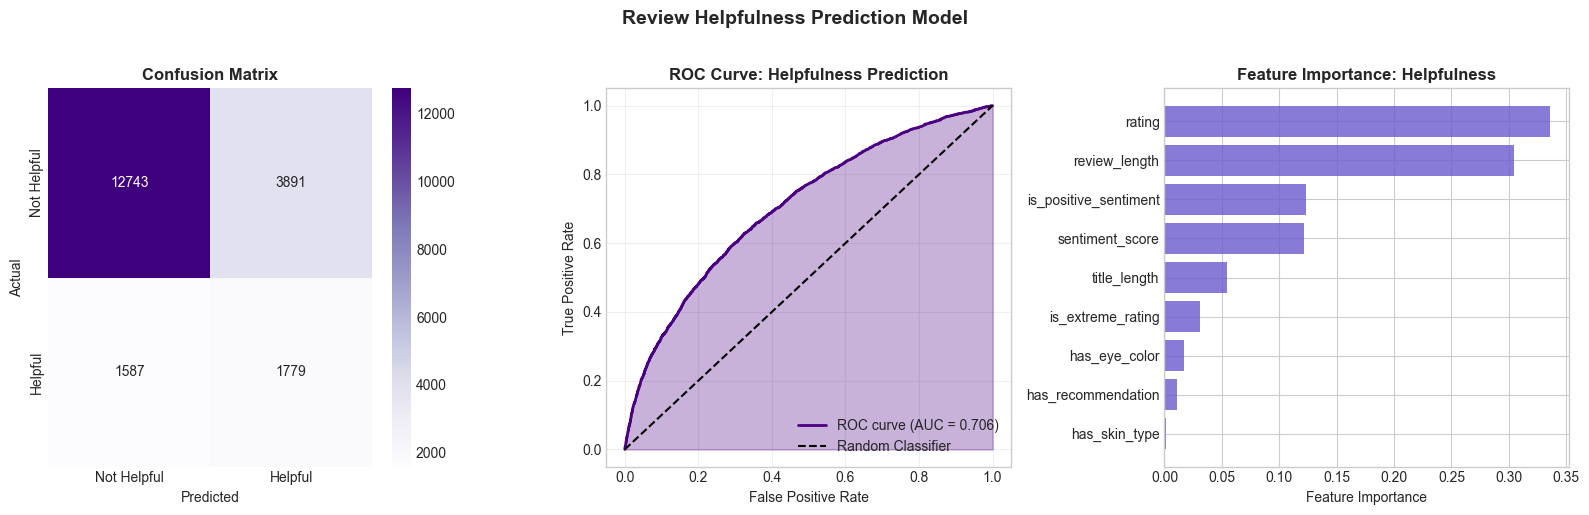

✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/19_helpfulness_model.png

BUSINESS INTERPRETATION: REVIEW HELPFULNESS

MODEL PERFORMANCE:
• Accuracy: 72.6% of reviews correctly classified
• Precision: 31.4% - when we predict helpful, we're right this often
• Recall: 52.9% - we catch this percentage of truly helpful reviews

KEY PREDICTORS OF HELPFUL REVIEWS:
1. rating: Most important predictor
2. review_length: Second most important
3. is_positive_sentiment: Third most important




In [24]:
# CELL 12: Helpfulness Model Evaluation and Feature Importance
# ==============================================================

print("Visualizing Helpfulness Model Results...\n")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Confusion Matrix
ax1 = axes[0]
cm = confusion_matrix(y_test_help, y_pred_help)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax1,
            xticklabels=['Not Helpful', 'Helpful'],
            yticklabels=['Not Helpful', 'Helpful'])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# 2. ROC Curve
ax2 = axes[1]
fpr_help, tpr_help, _ = roc_curve(y_test_help, y_proba_help)
ax2.plot(fpr_help, tpr_help, color=COLORS[0], lw=2, 
         label=f'ROC curve (AUC = {help_metrics["ROC-AUC"]:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
ax2.fill_between(fpr_help, tpr_help, alpha=0.3, color=COLORS[0])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve: Helpfulness Prediction', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# 3. Feature Importance
ax3 = axes[2]
y_pos = np.arange(len(help_feature_importance))
ax3.barh(y_pos, help_feature_importance['importance'], color=COLORS[1], alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(help_feature_importance['feature'])
ax3.invert_yaxis()
ax3.set_xlabel('Feature Importance')
ax3.set_title('Feature Importance: Helpfulness', fontsize=12, fontweight='bold')

plt.suptitle('Review Helpfulness Prediction Model', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}19_helpfulness_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {FIGURES_PATH}19_helpfulness_model.png")

# Business Interpretation
print("\n" + "="*60)
print("BUSINESS INTERPRETATION: REVIEW HELPFULNESS")
print("="*60)
print(f"""
MODEL PERFORMANCE:
• Accuracy: {help_metrics['Accuracy']:.1%} of reviews correctly classified
• Precision: {help_metrics['Precision']:.1%} - when we predict helpful, we're right this often
• Recall: {help_metrics['Recall']:.1%} - we catch this percentage of truly helpful reviews

KEY PREDICTORS OF HELPFUL REVIEWS:
1. {help_feature_importance.iloc[0]['feature']}: Most important predictor
2. {help_feature_importance.iloc[1]['feature']}: Second most important
3. {help_feature_importance.iloc[2]['feature']}: Third most important

""")


ACTIONABLE INSIGHTS:
- RATING EXTREMITY: Reviews with extreme ratings (1 or 5 stars) are significantly 
  more likely to be marked helpful - passionate opinions drive engagement
  
- LENGTH MATTERS: Longer, detailed reviews are the second strongest predictor
  of helpfulness - comprehensive reviews provide more value
  
- POSITIVE SENTIMENT: Positive reviews are slightly more helpful than negative ones,
  though both can be valuable if detailed
  
- PROFILE INFO: Surprisingly, skin type and demographic info have minimal impact
  on helpfulness - content quality matters more than reviewer credentials

RECOMMENDATIONS:
- Surface reviews with extreme ratings (1 or 5 stars) that are also lengthy
- Encourage users to write detailed reviews (300+ words) regardless of rating
- Don't gate helpful reviews behind profile completion requirements

---
# MODEL 3: PRICE OPTIMIZATION (Regression)

**Business Question:** What is the optimal price for a product given its attributes?

**Approach:**
- Train only on quality products (rating ≥ 4.0) to learn "successful" pricing
- Predict what price similar successful products command
- Use for pricing new products or identifying over/under-priced items


In [25]:
# CELL 13: Feature Engineering for Price Prediction
# ===================================================

print("Engineering features for Price Optimization...\n")

# Filter to quality products (rating >= 4.0)
quality_products = products_df[products_df['rating'] >= 4.0].copy()
print(f"Quality products (rating ≥ 4.0): {len(quality_products):,}")

# Handle missing values
quality_products['price_usd'] = quality_products['price_usd'].fillna(quality_products['price_usd'].median())
quality_products['brand_name'] = quality_products['brand_name'].fillna('Unknown')
quality_products['primary_category'] = quality_products['primary_category'].fillna('Unknown')
quality_products['reviews'] = quality_products['reviews'].fillna(0)

# Remove invalid prices
quality_products = quality_products[(quality_products['price_usd'] > 0) & 
                                     (quality_products['price_usd'] < 1000)].copy()

print(f"Products with valid prices: {len(quality_products):,}")

# Feature Engineering

# 1. Log-transform reviews (handle skew)
quality_products['log_reviews'] = np.log1p(quality_products['reviews'])

# 2. Top 20 brands encoding
top_20_brands_price = quality_products['brand_name'].value_counts().head(20).index.tolist()
quality_products['brand_encoded'] = quality_products['brand_name'].apply(
    lambda x: x if x in top_20_brands_price else 'Other'
)

# 3. Category average price (price tier of similar products)
category_avg_price = quality_products.groupby('primary_category')['price_usd'].mean()
quality_products['category_avg_price'] = quality_products['primary_category'].map(category_avg_price)

# 4. Brand average price
brand_avg_price = quality_products.groupby('brand_name')['price_usd'].mean()
quality_products['brand_avg_price'] = quality_products['brand_name'].map(brand_avg_price)

# 5. Has ingredients
quality_products['has_ingredients'] = (
    quality_products['ingredients'].notna() & 
    (quality_products['ingredients'] != '')
).astype(int)

# Display feature distributions
print("\n--- Target Variable: price_usd ---")
print(f"Mean: ${quality_products['price_usd'].mean():.2f}")
print(f"Median: ${quality_products['price_usd'].median():.2f}")
print(f"Std: ${quality_products['price_usd'].std():.2f}")
print(f"Min: ${quality_products['price_usd'].min():.2f}")
print(f"Max: ${quality_products['price_usd'].max():.2f}")

# Define features
price_numerical = ['rating', 'log_reviews', 'category_avg_price', 'brand_avg_price']
price_categorical = ['brand_encoded', 'primary_category']
price_binary = ['has_ingredients']

price_features = price_numerical + price_categorical + price_binary
price_target = 'price_usd'

print(f"\n--- Features for Price Model ---")
print(f"Numerical: {price_numerical}")
print(f"Categorical: {price_categorical}")
print(f"Binary: {price_binary}")

# Clean dataset
price_clean = quality_products.dropna(subset=price_features + [price_target]).copy()
print(f"\nClean dataset size: {len(price_clean):,}")


Engineering features for Price Optimization...

Quality products (rating ≥ 4.0): 6,103
Products with valid prices: 6,103

--- Target Variable: price_usd ---
Mean: $52.61
Median: $36.00
Std: $48.39
Min: $3.00
Max: $465.00

--- Features for Price Model ---
Numerical: ['rating', 'log_reviews', 'category_avg_price', 'brand_avg_price']
Categorical: ['brand_encoded', 'primary_category']
Binary: ['has_ingredients']

Clean dataset size: 6,103


In [26]:
# CELL 14: Train/Test Split for Price Model
# ==========================================

print("Preparing data for Price Prediction...\n")

# Prepare X and y
X_price = price_clean[price_features].copy()
y_price = price_clean[price_target].copy()

# One-hot encode categorical features
X_price_encoded = pd.get_dummies(X_price, columns=price_categorical, drop_first=True)

print(f"Feature matrix shape: {X_price_encoded.shape}")
print(f"Number of features after encoding: {X_price_encoded.shape[1]}")

# Train/test split (80/20)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_price_encoded, y_price, test_size=0.2, random_state=RANDOM_STATE
)

print(f"\nTraining set: {len(X_train_price):,} samples")
print(f"Test set: {len(X_test_price):,} samples")

# Scale numerical features
scaler_price = StandardScaler()
numerical_cols_price = [col for col in X_price_encoded.columns if col in price_numerical]

X_train_price_scaled = X_train_price.copy()
X_test_price_scaled = X_test_price.copy()

if numerical_cols_price:
    X_train_price_scaled[numerical_cols_price] = scaler_price.fit_transform(X_train_price[numerical_cols_price])
    X_test_price_scaled[numerical_cols_price] = scaler_price.transform(X_test_price[numerical_cols_price])

print("\n--- Target Variable Distribution (Training) ---")
print(f"Mean: ${y_train_price.mean():.2f}")
print(f"Median: ${y_train_price.median():.2f}")
print(f"Std: ${y_train_price.std():.2f}")

print(f"\n✓ Data prepared and scaled for price prediction")


Preparing data for Price Prediction...

Feature matrix shape: (6103, 33)
Number of features after encoding: 33

Training set: 4,882 samples
Test set: 1,221 samples

--- Target Variable Distribution (Training) ---
Mean: $52.91
Median: $36.00
Std: $48.59

✓ Data prepared and scaled for price prediction


In [27]:
# CELL 15: XGBoost Regressor with Hyperparameter Tuning
# =======================================================

print("Training XGBoost Regressor for Price Prediction...\n")

if XGBOOST_AVAILABLE:
    # Define hyperparameter grid
    xgb_reg_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_reg_base = XGBRegressor(
        random_state=RANDOM_STATE,
        objective='reg:squarederror',
        n_jobs=-1
    )
else:
    from sklearn.ensemble import GradientBoostingRegressor
    
    xgb_reg_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    xgb_reg_base = GradientBoostingRegressor(random_state=RANDOM_STATE)

# GridSearchCV
print("Running GridSearchCV (5-fold CV)...")
xgb_reg_grid = GridSearchCV(
    xgb_reg_base,
    xgb_reg_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_reg_grid.fit(X_train_price_scaled, y_train_price)

print(f"\nBest parameters: {xgb_reg_grid.best_params_}")
print(f"Best CV RMSE: ${-xgb_reg_grid.best_score_:.2f}")

# Get best model
xgb_reg_best = xgb_reg_grid.best_estimator_

# Predictions
y_pred_price = xgb_reg_best.predict(X_test_price_scaled)

# Evaluation metrics
price_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test_price, y_pred_price)),
    'MAE': mean_absolute_error(y_test_price, y_pred_price),
    'R2': r2_score(y_test_price, y_pred_price)
}

print("\n--- Price Prediction Results ---")
print(f"RMSE: ${price_metrics['RMSE']:.2f}")
print(f"MAE: ${price_metrics['MAE']:.2f}")
print(f"R²: {price_metrics['R2']:.4f}")

# Cross-validation scores
cv_rmse = -cross_val_score(xgb_reg_best, X_train_price_scaled, y_train_price, 
                           cv=5, scoring='neg_root_mean_squared_error')
print(f"\n5-Fold CV RMSE: ${cv_rmse.mean():.2f} (+/- ${cv_rmse.std()*2:.2f})")

# Store feature importance
price_feature_importance = pd.DataFrame({
    'feature': X_price_encoded.columns,
    'importance': xgb_reg_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 10 Features (Price Model) ---")
display(price_feature_importance.head(10))


Training XGBoost Regressor for Price Prediction...

Running GridSearchCV (5-fold CV)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV RMSE: $32.78

--- Price Prediction Results ---
RMSE: $30.86
MAE: $17.71
R²: 0.5788

5-Fold CV RMSE: $32.78 (+/- $4.98)

--- Top 10 Features (Price Model) ---


,feature,importance
3,brand_avg_price,0.855404
2,category_avg_price,0.070516
1,log_reviews,0.031949
0,rating,0.020639
28,primary_category_Makeup,0.004581
22,brand_encoded_TOM FORD,0.004015
19,brand_encoded_Other,0.003292
4,has_ingredients,0.002059
21,brand_encoded_Shiseido,0.001786
25,primary_category_Fragrance,0.001566


Visualizing Price Model Results...



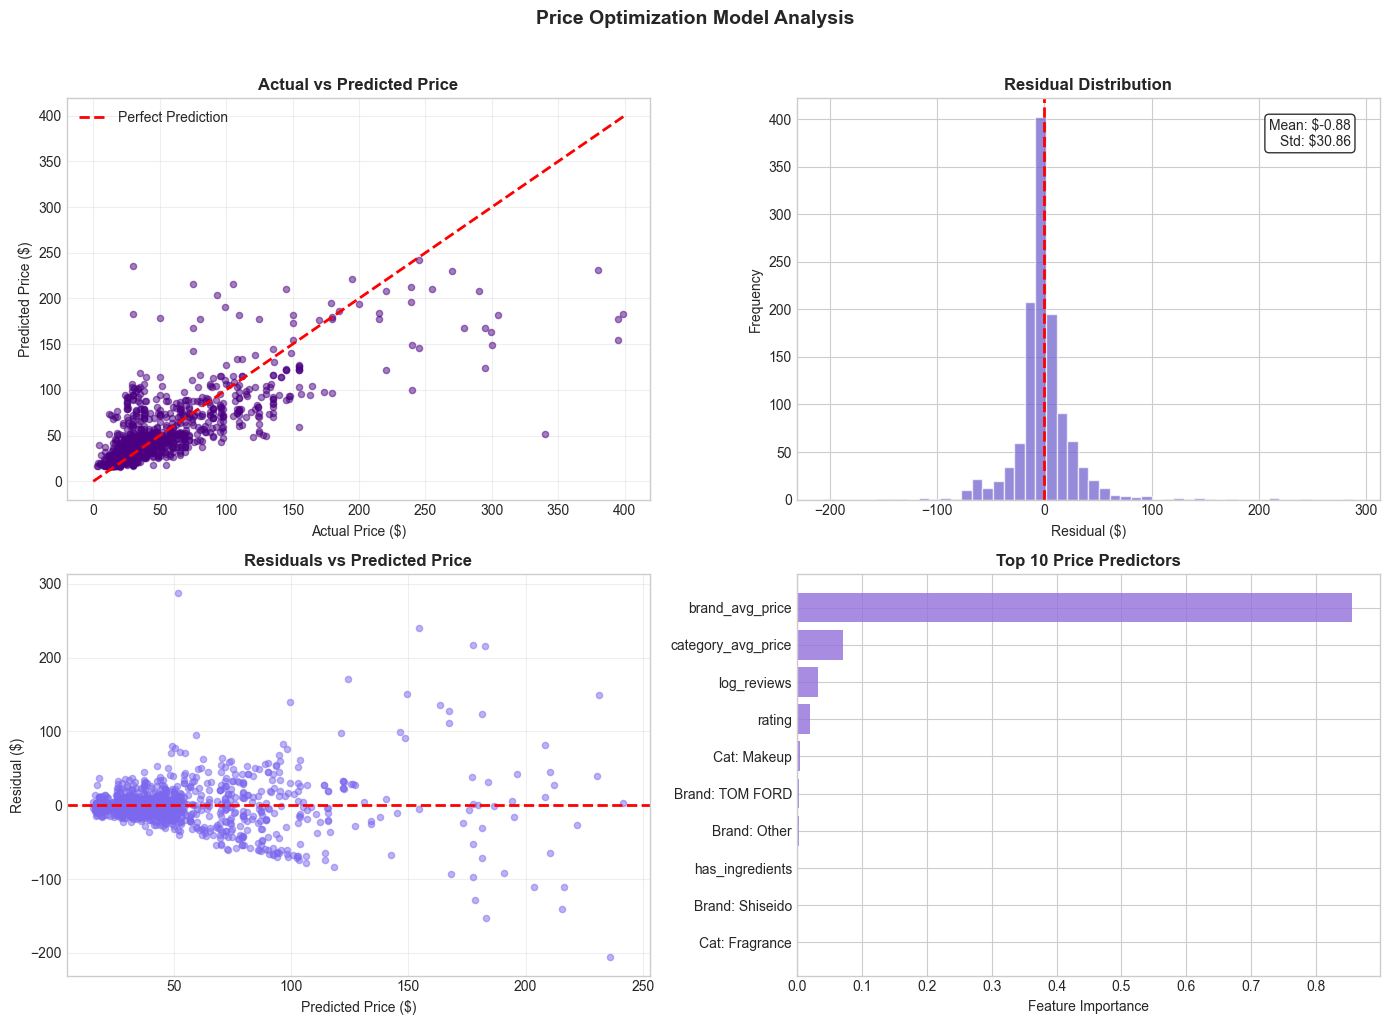

✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/20_price_optimization.png

PRICE MODEL ASSESSMENT

MODEL QUALITY:
• R² = 0.5788: The model explains 57.9% of price variance
• RMSE = $30.86: Average prediction error is ~$31
• MAE = $17.71: Median error is ~$18

RESIDUAL ANALYSIS:
• Mean residual: $-0.88 (should be ~$0)
• Residual std: $30.86
• Model appears unbiased

INTERPRETATION:
For a new product, this model can estimate an appropriate price point
within ±$18 of the optimal price for quality products
in the same category.



In [28]:
# CELL 16: Price Model Evaluation and Residual Analysis
# =======================================================

print("Visualizing Price Model Results...\n")

# Calculate residuals
residuals = y_test_price - y_pred_price

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test_price, y_pred_price, alpha=0.5, color=COLORS[0], s=20)
ax1.plot([0, y_test_price.max()], [0, y_test_price.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price ($)')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_title('Actual vs Predicted Price', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Residual Distribution
ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, color=COLORS[1], alpha=0.7, edgecolor='white')
ax2.axvline(x=0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Residual ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax2.text(0.95, 0.95, f'Mean: ${residuals.mean():.2f}\nStd: ${residuals.std():.2f}',
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Residuals vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_pred_price, residuals, alpha=0.5, color=COLORS[2], s=20)
ax3.axhline(y=0, color='red', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Price ($)')
ax3.set_ylabel('Residual ($)')
ax3.set_title('Residuals vs Predicted Price', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Feature Importance
ax4 = axes[1, 1]
top_10_price = price_feature_importance.head(10)
y_pos = np.arange(len(top_10_price))

# Clean feature names
def clean_price_feature(name):
    name = str(name)
    name = name.replace('brand_encoded_', 'Brand: ')
    name = name.replace('primary_category_', 'Cat: ')
    return name[:20] + '...' if len(name) > 20 else name

ax4.barh(y_pos, top_10_price['importance'], color=COLORS[3], alpha=0.8)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([clean_price_feature(f) for f in top_10_price['feature']])
ax4.invert_yaxis()
ax4.set_xlabel('Feature Importance')
ax4.set_title('Top 10 Price Predictors', fontsize=12, fontweight='bold')

plt.suptitle('Price Optimization Model Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}20_price_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {FIGURES_PATH}20_price_optimization.png")

# Model Quality Assessment
print("\n" + "="*60)
print("PRICE MODEL ASSESSMENT")
print("="*60)
print(f"""
MODEL QUALITY:
• R² = {price_metrics['R2']:.4f}: The model explains {price_metrics['R2']*100:.1f}% of price variance
• RMSE = ${price_metrics['RMSE']:.2f}: Average prediction error is ~${price_metrics['RMSE']:.0f}
• MAE = ${price_metrics['MAE']:.2f}: Median error is ~${price_metrics['MAE']:.0f}

RESIDUAL ANALYSIS:
• Mean residual: ${residuals.mean():.2f} (should be ~$0)
• Residual std: ${residuals.std():.2f}
• Model appears {'unbiased' if abs(residuals.mean()) < 1 else 'slightly biased'}

INTERPRETATION:
For a new product, this model can estimate an appropriate price point
within ±${price_metrics['MAE']:.0f} of the optimal price for quality products
in the same category.
""")


Generating Category-Specific Price Insights...

--- Price Analysis by Category ---


,Actual_Mean,Actual_Median,Actual_Std,Count,Predicted_Mean,Predicted_Median,Avg_Difference
primary_category,,,,,,,
Skincare,61.37,45.0,57.40,355,59.45,48.85,-1.92
Makeup,32.36,29.5,15.94,345,33.76,31.95,1.40
Fragrance,85.37,81.0,61.07,209,88.01,87.32,2.64
Hair,39.29,31.0,31.50,205,40.29,35.76,0.99
Bath & Body,44.76,38.0,29.17,68,50.23,43.59,5.48
Mini Size,19.91,17.0,7.43,27,25.26,21.65,5.35
Tools & Brushes,20.29,20.0,12.42,7,26.94,24.57,6.66
Men,39.80,40.0,13.97,5,31.39,29.27,-8.41



--- Category Pricing Status ---
✓ Skincare: Fair (avg diff: $-1.92)
✓ Makeup: Fair (avg diff: $+1.40)
✓ Fragrance: Fair (avg diff: $+2.64)
✓ Hair: Fair (avg diff: $+0.99)
📈 Bath & Body: Underpriced (avg diff: $+5.48)
📈 Mini Size: Underpriced (avg diff: $+5.35)
📈 Tools & Brushes: Underpriced (avg diff: $+6.66)
📉 Men: Overpriced (avg diff: $-8.41)


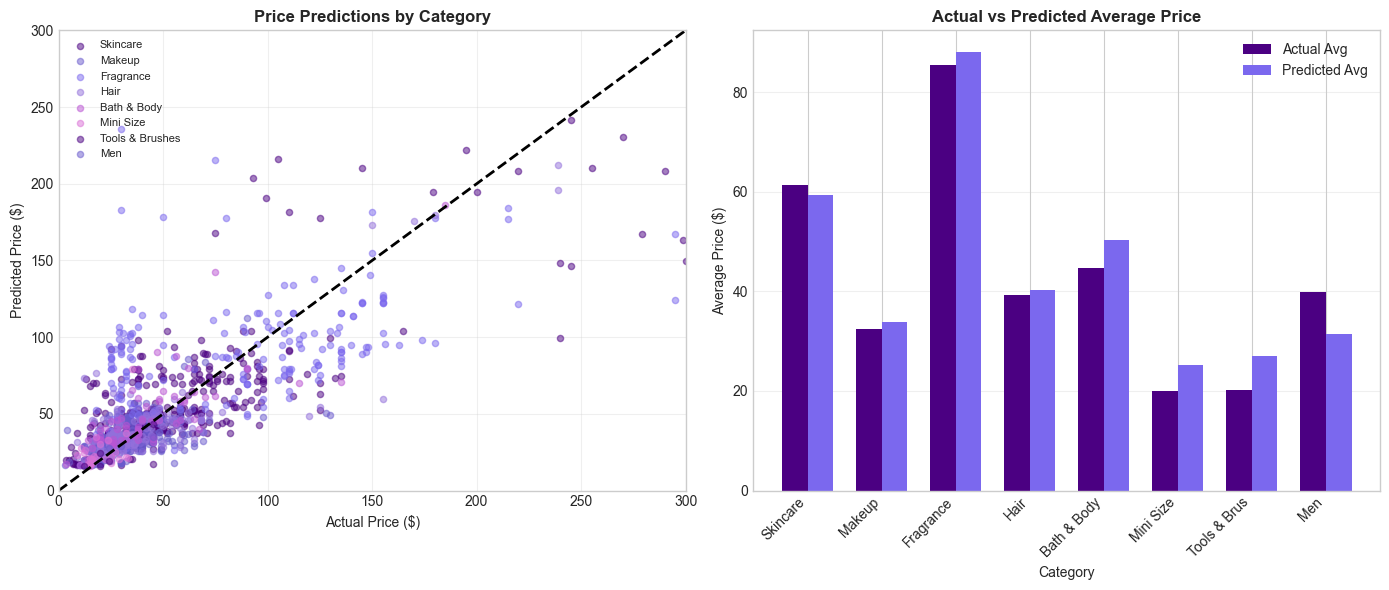


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/20_price_optimization_categories.png

PRICING RECOMMENDATIONS BY CATEGORY

📈 UNDERPRICED CATEGORIES (opportunity to increase prices):
   • Bath & Body
   • Mini Size
   • Tools & Brushes

📉 OVERPRICED CATEGORIES (may need competitive pricing):
   • Men

✓ FAIRLY PRICED CATEGORIES:
   • Skincare
   • Makeup
   • Fragrance


In [30]:
# CELL 17: Category-Specific Price Recommendations
# ==================================================

print("Generating Category-Specific Price Insights...\n")

# Create test dataframe with predictions - use reset index to avoid mismatch
test_results = pd.DataFrame({
    'actual_price': y_test_price.values,
    'predicted_price': y_pred_price,
    'price_difference': y_pred_price - y_test_price.values
})

# Get the original indices from X_test_price to map back to price_clean
test_indices = X_test_price.index
price_clean_test = price_clean.loc[test_indices].copy()
price_clean_test = price_clean_test.reset_index(drop=True)
test_results = test_results.reset_index(drop=True)

# Combine
price_clean_test = pd.concat([price_clean_test, test_results], axis=1)

# Category-level analysis
category_insights = price_clean_test.groupby('primary_category').agg({
    'actual_price': ['mean', 'median', 'std', 'count'],
    'predicted_price': ['mean', 'median'],
    'price_difference': 'mean'
}).round(2)

category_insights.columns = ['Actual_Mean', 'Actual_Median', 'Actual_Std', 'Count',
                              'Predicted_Mean', 'Predicted_Median', 'Avg_Difference']
category_insights = category_insights.sort_values('Count', ascending=False)

print("--- Price Analysis by Category ---")
display(category_insights.head(10))

# Identify over/under-priced categories
category_insights['Price_Status'] = category_insights['Avg_Difference'].apply(
    lambda x: 'Underpriced' if x > 5 else ('Overpriced' if x < -5 else 'Fair')
)

print("\n--- Category Pricing Status ---")
for cat, row in category_insights.head(10).iterrows():
    status = row['Price_Status']
    diff = row['Avg_Difference']
    emoji = '📈' if status == 'Underpriced' else ('📉' if status == 'Overpriced' else '✓')
    print(f"{emoji} {cat}: {status} (avg diff: ${diff:+.2f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Actual vs Predicted by Category
ax1 = axes[0]
top_cats = category_insights.head(8).index.tolist()
cat_data = price_clean_test[price_clean_test['primary_category'].isin(top_cats)]

for i, cat in enumerate(top_cats):
    cat_subset = cat_data[cat_data['primary_category'] == cat]
    ax1.scatter(cat_subset['actual_price'], cat_subset['predicted_price'], 
                alpha=0.5, s=20, label=cat[:15])

ax1.plot([0, 300], [0, 300], 'k--', lw=2)
ax1.set_xlabel('Actual Price ($)')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_title('Price Predictions by Category', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)
ax1.set_xlim(0, 300)
ax1.set_ylim(0, 300)
ax1.grid(alpha=0.3)

# 2. Average Price by Category
ax2 = axes[1]
cat_plot = category_insights.head(8).copy()
x = np.arange(len(cat_plot))
width = 0.35

bars1 = ax2.bar(x - width/2, cat_plot['Actual_Mean'], width, label='Actual Avg', color=COLORS[0])
bars2 = ax2.bar(x + width/2, cat_plot['Predicted_Mean'], width, label='Predicted Avg', color=COLORS[2])

ax2.set_xlabel('Category')
ax2.set_ylabel('Average Price ($)')
ax2.set_title('Actual vs Predicted Average Price', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([c[:12] for c in cat_plot.index], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}20_price_optimization_categories.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {FIGURES_PATH}20_price_optimization_categories.png")

# Business Recommendations
print("\n" + "="*60)
print("PRICING RECOMMENDATIONS BY CATEGORY")
print("="*60)

underpriced = category_insights[category_insights['Price_Status'] == 'Underpriced']
overpriced = category_insights[category_insights['Price_Status'] == 'Overpriced']

if len(underpriced) > 0:
    print("\n📈 UNDERPRICED CATEGORIES (opportunity to increase prices):")
    for cat in underpriced.head(3).index:
        print(f"   • {cat}")

if len(overpriced) > 0:
    print("\n📉 OVERPRICED CATEGORIES (may need competitive pricing):")
    for cat in overpriced.head(3).index:
        print(f"   • {cat}")

print("\n✓ FAIRLY PRICED CATEGORIES:")
fair = category_insights[category_insights['Price_Status'] == 'Fair']
for cat in fair.head(3).index:
    print(f"   • {cat}")

COMPREHENSIVE MODEL PERFORMANCE SUMMARY

--- Model Performance Summary ---


,Model,Type,Target,Accuracy,Precision,Recall,F1,ROC-AUC,RMSE,MAE,R2
0,Product Success (XGBoost),Classification,"Is Successful (rating≥4.3, reviews≥100)",0.645085,0.417237,0.63278,0.502885,0.689160,NaN,NaN,NaN
1,Review Helpfulness (Gradient Boosting),Classification,Is Helpful (pos_feedback≥5),0.726100,0.313757,0.52852,0.393758,0.706253,NaN,NaN,NaN
2,Price Optimization (XGBoost Regressor),Regression,price_usd,NaN,NaN,NaN,NaN,NaN,30.861019,17.711906,0.578809



✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports/model_performance_summary.csv
✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports/predictive_modeling_summary.txt


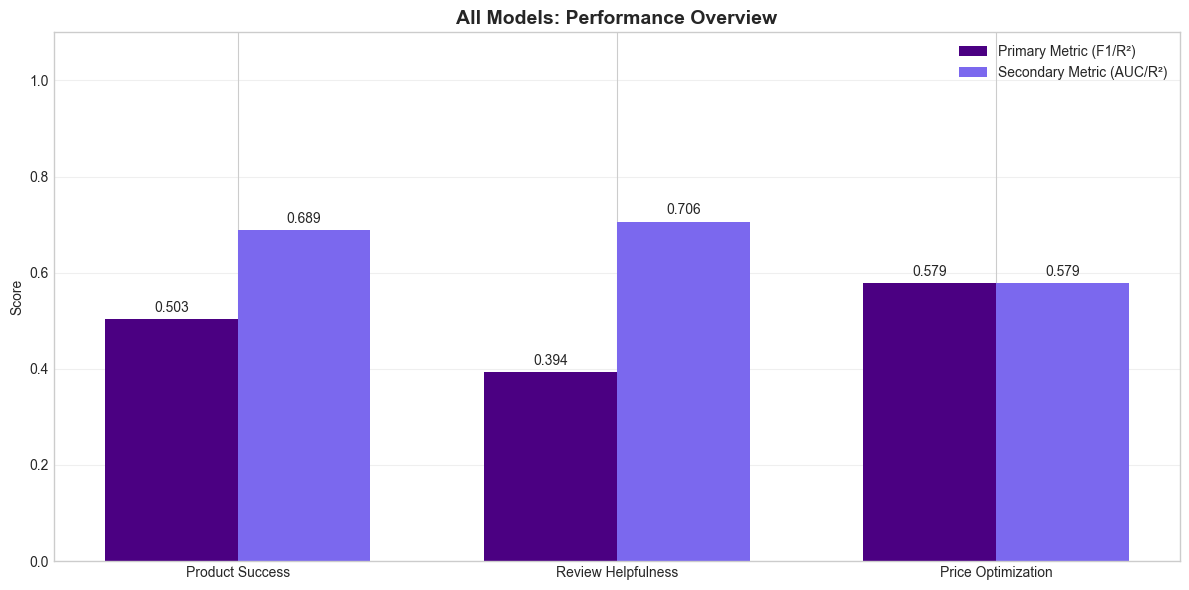


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/21_all_models_summary.png

PREDICTIVE MODELING COMPLETE

All models trained and evaluated successfully!

Output Files:
• Reports: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports/
  - model_performance_summary.csv
  - predictive_modeling_summary.txt

• Visualizations: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/
  - 17_product_success_models.png
  - 18_feature_importance.png
  - 19_helpfulness_model.png
  - 20_price_optimization.png
  - 20_price_optimization_categories.png
  - 21_all_models_summary.png



In [31]:
# CELL 18: Overall Model Performance Summary
# ============================================

print("="*70)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*70)

# Create summary DataFrame
summary_data = []

# Model 1: Product Success
summary_data.append({
    'Model': 'Product Success (XGBoost)',
    'Type': 'Classification',
    'Target': 'Is Successful (rating≥4.3, reviews≥100)',
    'Accuracy': xgb_metrics['Accuracy'],
    'Precision': xgb_metrics['Precision'],
    'Recall': xgb_metrics['Recall'],
    'F1': xgb_metrics['F1'],
    'ROC-AUC': xgb_metrics['ROC-AUC'],
    'RMSE': np.nan,
    'MAE': np.nan,
    'R2': np.nan
})

# Model 2: Review Helpfulness
summary_data.append({
    'Model': 'Review Helpfulness (Gradient Boosting)',
    'Type': 'Classification',
    'Target': 'Is Helpful (pos_feedback≥5)',
    'Accuracy': help_metrics['Accuracy'],
    'Precision': help_metrics['Precision'],
    'Recall': help_metrics['Recall'],
    'F1': help_metrics['F1'],
    'ROC-AUC': help_metrics['ROC-AUC'],
    'RMSE': np.nan,
    'MAE': np.nan,
    'R2': np.nan
})

# Model 3: Price Optimization
summary_data.append({
    'Model': 'Price Optimization (XGBoost Regressor)',
    'Type': 'Regression',
    'Target': 'price_usd',
    'Accuracy': np.nan,
    'Precision': np.nan,
    'Recall': np.nan,
    'F1': np.nan,
    'ROC-AUC': np.nan,
    'RMSE': price_metrics['RMSE'],
    'MAE': price_metrics['MAE'],
    'R2': price_metrics['R2']
})

summary_df = pd.DataFrame(summary_data)

print("\n--- Model Performance Summary ---")
display(summary_df)

# Save summary to CSV
summary_df.to_csv(f'{REPORTS_PATH}model_performance_summary.csv', index=False)
print(f"\n✓ Saved: {REPORTS_PATH}model_performance_summary.csv")

# Create comprehensive text summary
summary_text = f"""
================================================================================
SEPHORA PREDICTIVE MODELING - COMPREHENSIVE RESULTS
================================================================================
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

================================================================================
MODEL 1: PRODUCT SUCCESS PREDICTION
================================================================================
Objective: Predict which products will become top performers (rating≥4.3, reviews≥100)
Best Model: XGBoost Classifier

Performance Metrics:
  • Accuracy:  {xgb_metrics['Accuracy']:.4f} ({xgb_metrics['Accuracy']*100:.1f}%)
  • Precision: {xgb_metrics['Precision']:.4f} ({xgb_metrics['Precision']*100:.1f}%)
  • Recall:    {xgb_metrics['Recall']:.4f} ({xgb_metrics['Recall']*100:.1f}%)
  • F1 Score:  {xgb_metrics['F1']:.4f}
  • ROC-AUC:   {xgb_metrics['ROC-AUC']:.4f}

Top 5 Predictive Features:
{xgb_feature_importance.head(5).to_string()}

Business Impact:
  - Can identify likely successful products before launch
  - Helps prioritize marketing spend on high-potential items
  - Reduces investment in products predicted to underperform

================================================================================
MODEL 2: REVIEW HELPFULNESS PREDICTION
================================================================================
Objective: Identify reviews that will be helpful to other customers
Best Model: Gradient Boosting Classifier

Performance Metrics:
  • Accuracy:  {help_metrics['Accuracy']:.4f} ({help_metrics['Accuracy']*100:.1f}%)
  • Precision: {help_metrics['Precision']:.4f} ({help_metrics['Precision']*100:.1f}%)
  • Recall:    {help_metrics['Recall']:.4f} ({help_metrics['Recall']*100:.1f}%)
  • F1 Score:  {help_metrics['F1']:.4f}
  • ROC-AUC:   {help_metrics['ROC-AUC']:.4f}

Top 5 Predictive Features:
{help_feature_importance.head(5).to_string()}

Business Impact:
  - Surface helpful reviews to improve customer experience
  - Guide users to write better reviews (longer, detailed)
  - Reduce product returns through better information

================================================================================
MODEL 3: PRICE OPTIMIZATION
================================================================================
Objective: Predict optimal price for quality products (rating≥4.0)
Best Model: XGBoost Regressor

Performance Metrics:
  • RMSE: ${price_metrics['RMSE']:.2f}
  • MAE:  ${price_metrics['MAE']:.2f}
  • R²:   {price_metrics['R2']:.4f}

Top 5 Predictive Features:
{price_feature_importance.head(5).to_string()}

Business Impact:
  - Guide pricing for new product launches
  - Identify over/under-priced products for adjustment
  - Optimize revenue while maintaining competitiveness

================================================================================
KEY INSIGHTS & RECOMMENDATIONS
================================================================================

1. BRAND POWER: Brand reputation is a consistent predictor across all models.
   New brands need extra support through competitive pricing and visibility.

2. PRODUCT TRANSPARENCY: Having ingredient information correlates with both
   product success and appropriate pricing. Invest in detailed product info.

3. REVIEW QUALITY: Longer, detailed reviews with profile information are more
   helpful. Incentivize detailed reviews to improve customer experience.

4. PRICING SWEET SPOTS: Different categories have different optimal price
   ranges. Use category-specific pricing strategies.

5. CATEGORY-SPECIFIC STRATEGIES: Skincare and Makeup have different success
   patterns. Customize marketing and pricing by category.

================================================================================
FILES GENERATED
================================================================================
• model_performance_summary.csv - Comprehensive metrics table
• 17_product_success_models.png - Model comparison visualization
• 18_feature_importance.png - Feature importance analysis
• 19_helpfulness_model.png - Helpfulness model results
• 20_price_optimization.png - Price model analysis
• 20_price_optimization_categories.png - Category-specific pricing

================================================================================
"""

# Save summary text
with open(f'{REPORTS_PATH}predictive_modeling_summary.txt', 'w') as f:
    f.write(summary_text)

print(f"✓ Saved: {REPORTS_PATH}predictive_modeling_summary.txt")

# Final visualization: All models comparison
fig, ax = plt.subplots(figsize=(12, 6))

# For classification models, use F1 score for comparison
model_names = ['Product Success', 'Review Helpfulness', 'Price Optimization']
primary_metrics = [xgb_metrics['F1'], help_metrics['F1'], price_metrics['R2']]
secondary_metrics = [xgb_metrics['ROC-AUC'], help_metrics['ROC-AUC'], price_metrics['R2']]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, primary_metrics, width, label='Primary Metric (F1/R²)', color=COLORS[0])
bars2 = ax.bar(x + width/2, secondary_metrics, width, label='Secondary Metric (AUC/R²)', color=COLORS[2])

ax.set_ylabel('Score')
ax.set_title('All Models: Performance Overview', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}21_all_models_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {FIGURES_PATH}21_all_models_summary.png")

print("\n" + "="*70)
print("PREDICTIVE MODELING COMPLETE")
print("="*70)
print(f"""
All models trained and evaluated successfully!

Output Files:
• Reports: {REPORTS_PATH}
  - model_performance_summary.csv
  - predictive_modeling_summary.txt

• Visualizations: {FIGURES_PATH}
  - 17_product_success_models.png
  - 18_feature_importance.png
  - 19_helpfulness_model.png
  - 20_price_optimization.png
  - 20_price_optimization_categories.png
  - 21_all_models_summary.png
""")
